# Vehicle Routing Problem with Time Windows
This notebook contains an example of how to use the PyVRP library to solve the Vehicle Routing Problem with Time Windows (VRPTW).

## Basic example
We'll start with a basic example that loads an instance and solves it using a standard configuration. First, let's import some necessary components.

In [1]:
import sys
import numpy as np
from typing import Callable, Dict, List, Optional
from functools import partial
from pathlib import Path
from IPython.display import display

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    PenaltyManager,
    Population,
    ProblemData,
    Result,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange
from pyvrp.diversity import broken_pairs_distance
from pyvrp.educate import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

import vrplib

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Make sure data_dir exists
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

### Read and plot instance
Now we will download an instance using the [vrplib](https://pypi.org/project/vrplib/) library. `pyvrp.read` will also use this library to read the problem and convert it to a `ProblemData` instance. We can read both `solomon` and `vrplib` instance formats. By passing `round_func='trunc1'`, we will compute distances with 1 decimal precision, by multipliying all distances by 10 and converting to integers (i.e. following the [DIMACS VRP challenge](http://dimacs.rutgers.edu/programs/challenge/vrp/) convention).

In [3]:
# Create data directory
solomon_dir = data_dir / "vrptw" / "Solomon"
solomon_dir.mkdir(parents=True, exist_ok=True)

# Download an instance and best known solution
instance_name = "RC208"
instance_filename = solomon_dir / f"{instance_name}.vrp"
if not instance_filename.exists():
    vrplib.download_instance(instance_name, instance_filename)
instance_bks_filename = solomon_dir / f"{instance_name}.sol"
if not instance_bks_filename.exists():
    vrplib.download_solution(instance_name, instance_bks_filename)

# Load instance and convert to ProblemData, scaling by 10 to truncate at 1 decimal
instance = read(
    instance_filename, instance_format="solomon", round_func="trunc1"
)
instance_bks = vrplib.read_solution(instance_bks_filename)

Let's plot the instance and see what we have. The function `plotting.plot_instance` will plot time_windows, demands and coordinates, which should give us a good impression of what the instance looks like (note that these can also be plotted separately using the `plotting.plot_*` functions.

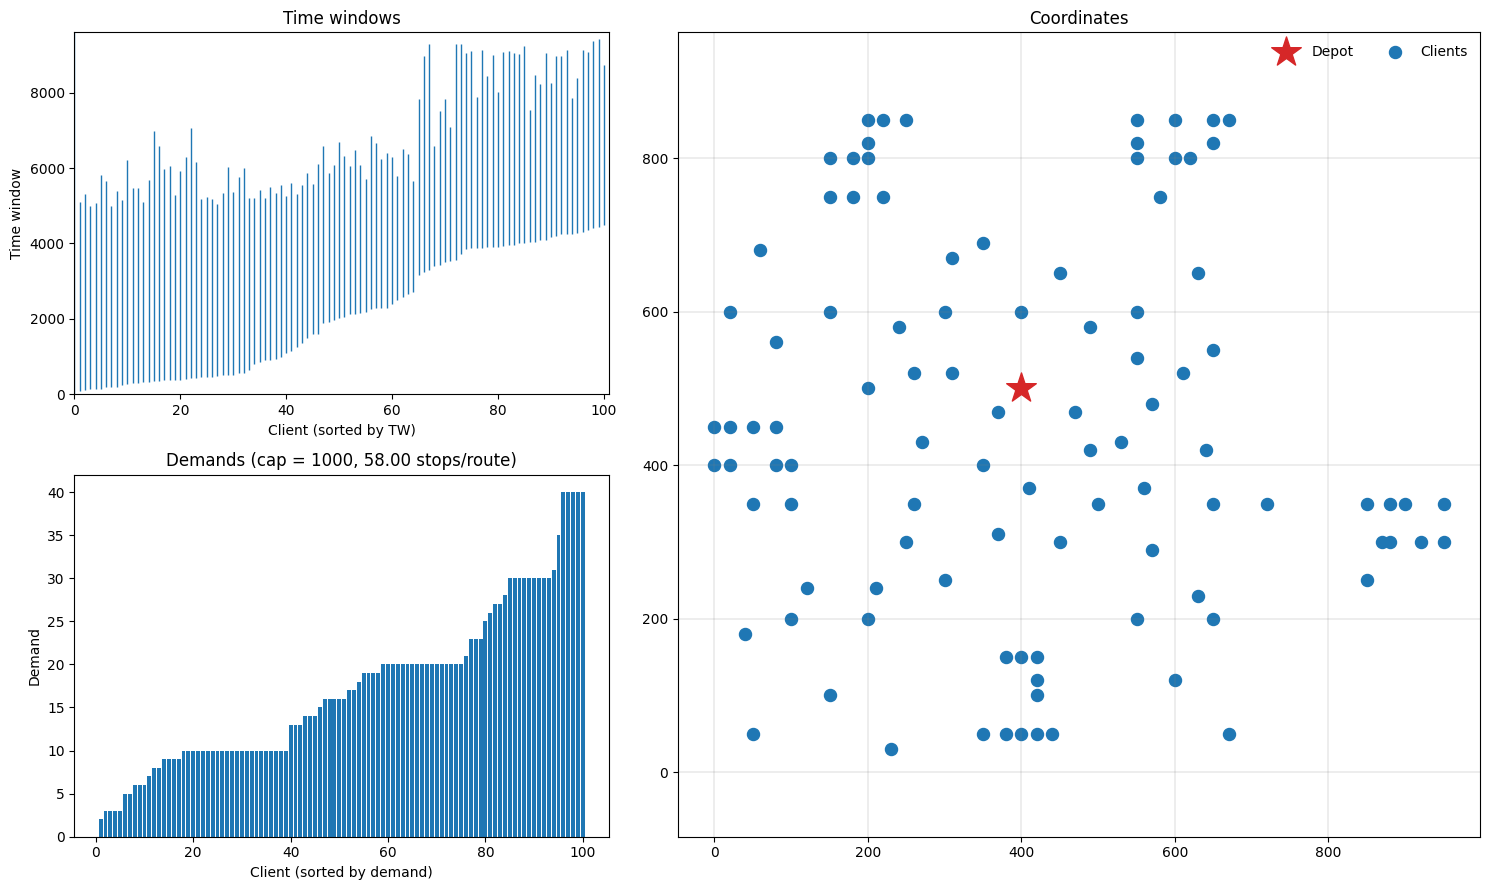

In [4]:
fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance, fig)

### Configure & run Hybrid Genetic Search
Now we will implement the `solve` function that sets up the necessary components of the Hybrid Genetic Search: the `Population`, `LocalSearch` object, where we can specify which operators we want to use, and the `PenaltyManager`. Then we will create the `GeneticAlgorithm` object and run it until our desired `StoppingCriterion` is met.

In [5]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)
    pop = Population(data, pen_manager, rng, broken_pairs_distance)
    ls = LocalSearch(data, pen_manager, rng)
    ls.set_neighbours(compute_neighbours(data))

    node_ops = [node_op(data, pen_manager) for node_op in NODE_OPERATORS]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops = [route_op(data, pen_manager) for route_op in ROUTE_OPERATORS]

    for op in route_ops:
        ls.add_route_operator(op)

    crossover_op = selective_route_exchange
    ga_params = GeneticAlgorithmParams(collect_statistics=True)
    algo = GeneticAlgorithm(
        data, pen_manager, rng, pop, ls, crossover_op, ga_params
    )

    if max_runtime is not None:
        stop: StoppingCriterion = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

Now let's run the algorithm using our `solve` function and print the result.

In [6]:
args = {"seed": 42, "max_runtime": 10}
result = solve(instance, **args)
solution = result.best
# Note the scaling of the solution cost
print(
    f"Total cost of solution: {solution.cost() / 10}, BKS = {instance_bks['cost']}"
)

Total cost of solution: 776.1, BKS = 776.1


### Plot results
The `result` object (of type `Result`) contains usefull statistics about the optimization since we set `collect_statistics=True` in `GeneticAlgorithmParams` (see the `solve` function). We can now plot these statistics as well as the final solution use `plotting.plot_result`.

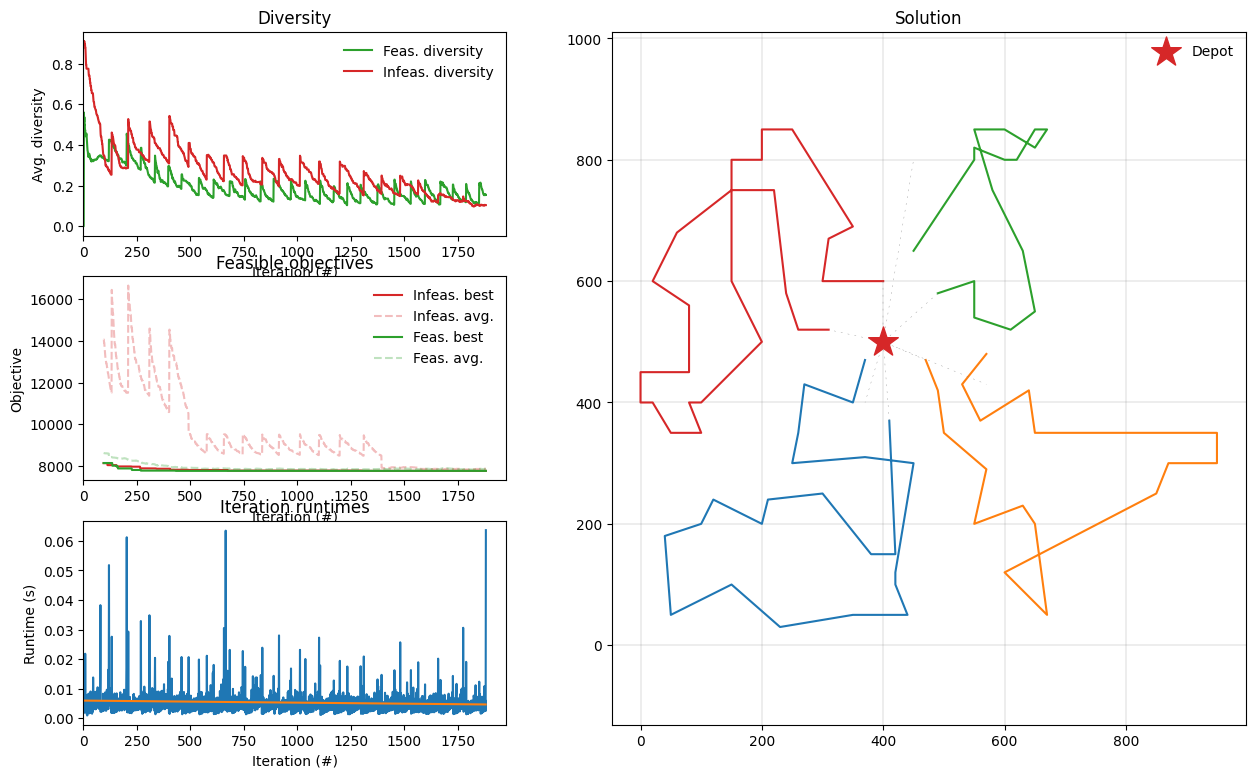

In [7]:
fig = plt.figure(figsize=(15, 9))
plotting.plot_result(result, instance, fig)

### Inspect routes
We can also inspect some statistics of the different routes, such as length/duration, number of stops and total demand, using `diagnostics.get_all_route_statistics`. Let's verify that the cost of our solution is equal to the some of the distances.

In [8]:
route_stats = diagnostics.get_all_route_statistics(solution, instance)
# Verify that cost is equal to total distance
assert sum([s.distance for s in route_stats]) == solution.cost()

route_stats_df = pd.DataFrame(route_stats)
assert route_stats_df["distance"].sum() == solution.cost()
display(route_stats_df.head())

,distance,start_time,end_time,duration,timewarp,wait_time,service_time,num_stops,total_demand,fillrate,is_feasible,is_empty
0,2187,0,7043,7043,0,2156,2700,27,465,0.465,True,False
1,1983,0,6862,6862,0,2479,2400,24,381,0.381,True,False
2,1325,0,6016,6016,0,2991,1700,17,286,0.286,True,False
3,2266,0,7295,7295,0,1829,3200,32,592,0.592,True,False
4,0,0,0,0,0,0,0,0,0,0.000,True,True


We can inspect the routes in more detail using the `plotting.plot_route_schedule` function. This will plot distance on the x-axis, and time on the y-axis, separating actual travel/driving time from waiting and service time. The clients visited are plotted as vertical bars indicating their time windows. When a vehicle arrives too early at a customer, we can see a jump to the start of the time window in the main (earliest) time line. In some cases, there is slack in the route indicated by a semi-transparent region on top of the earliest time line. The gray background indicates the remaining load of the truck during the route, where the (right) y-axis ends at the vehicle capacity.

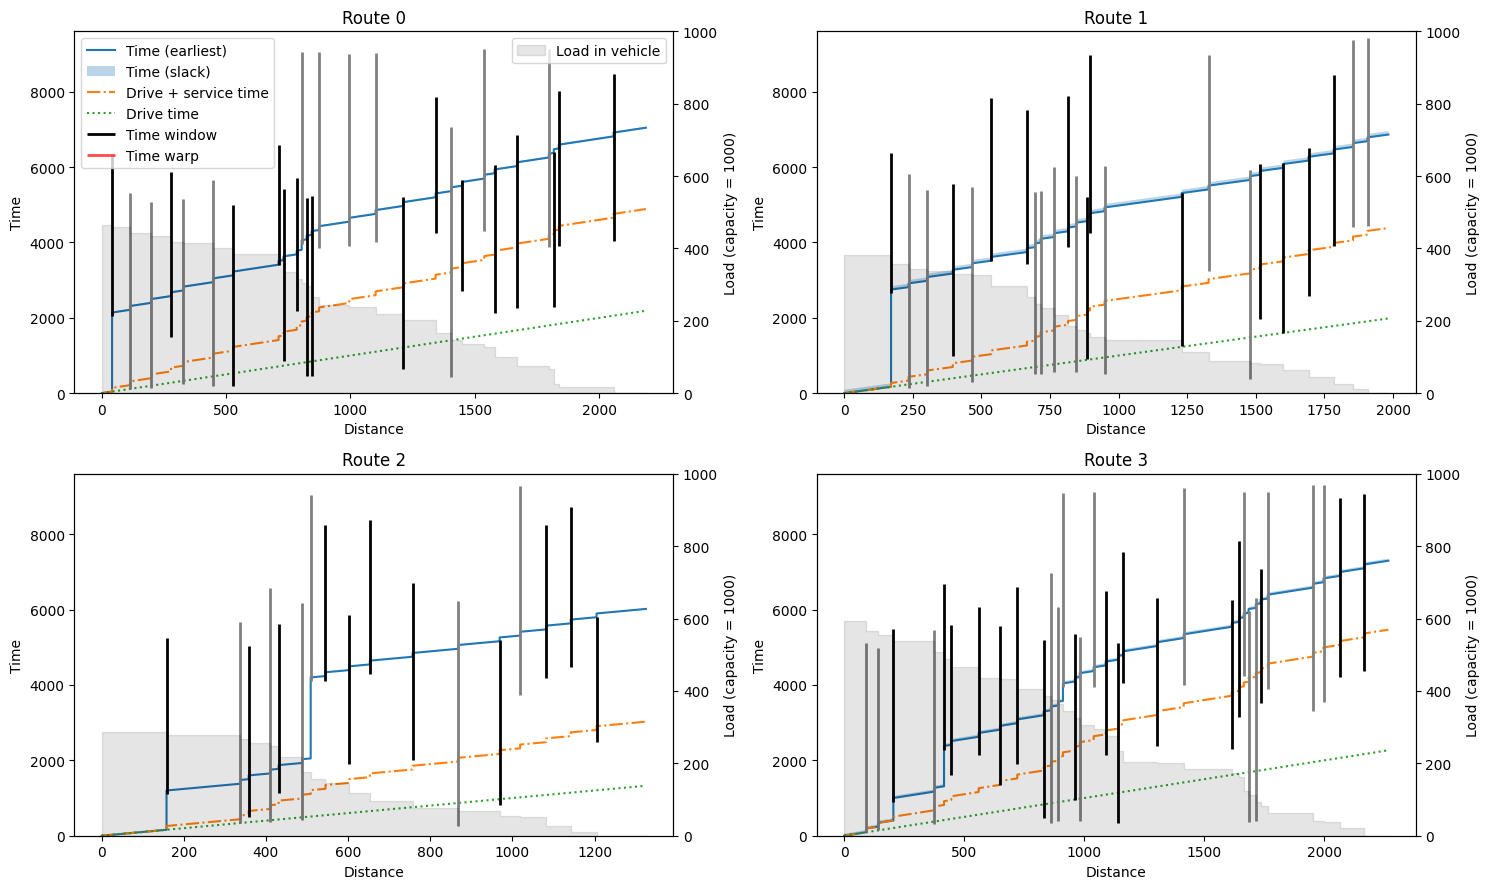

In [9]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
routes = solution.get_routes()
for i, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
    plotting.plot_route_schedule(
        instance, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()

## Running larger instances
PyVRP can also handle larger instances, although running times to reach high quality solutions may be longer.

### Gehring & Homberger instance
Let's try one of the largest Gehring & Homberger instances (1000 customers), and plot the instance, results and some routes.

Total cost of solution: 27543.1, BKS = 25797.5


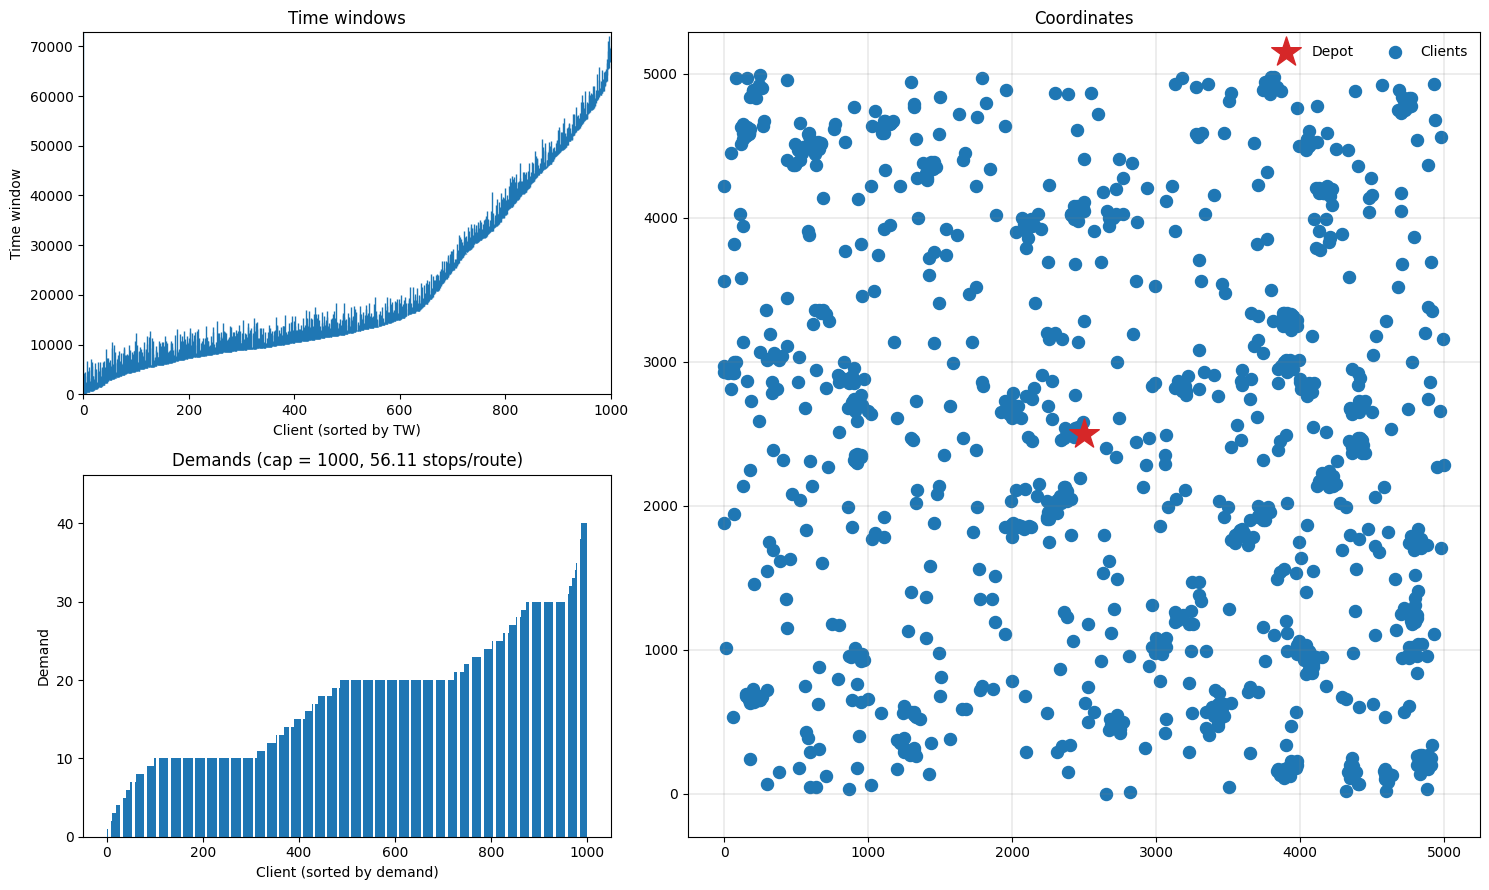

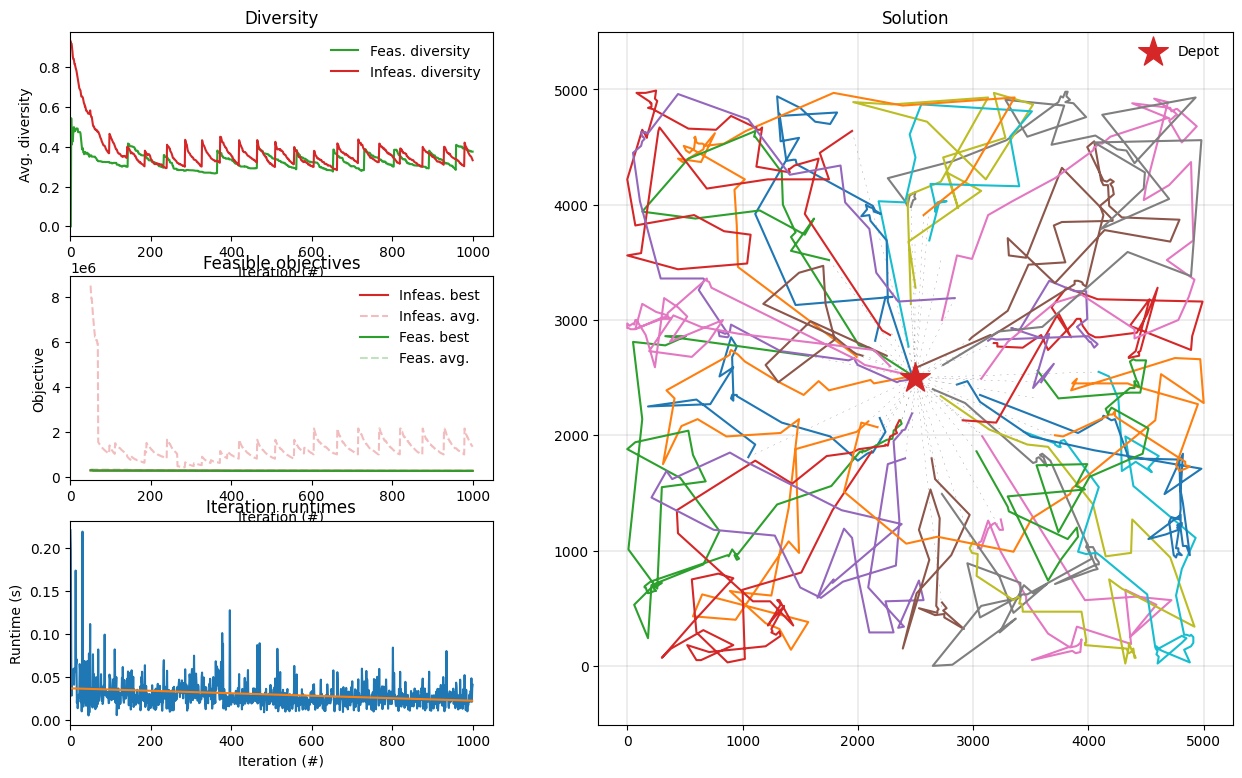

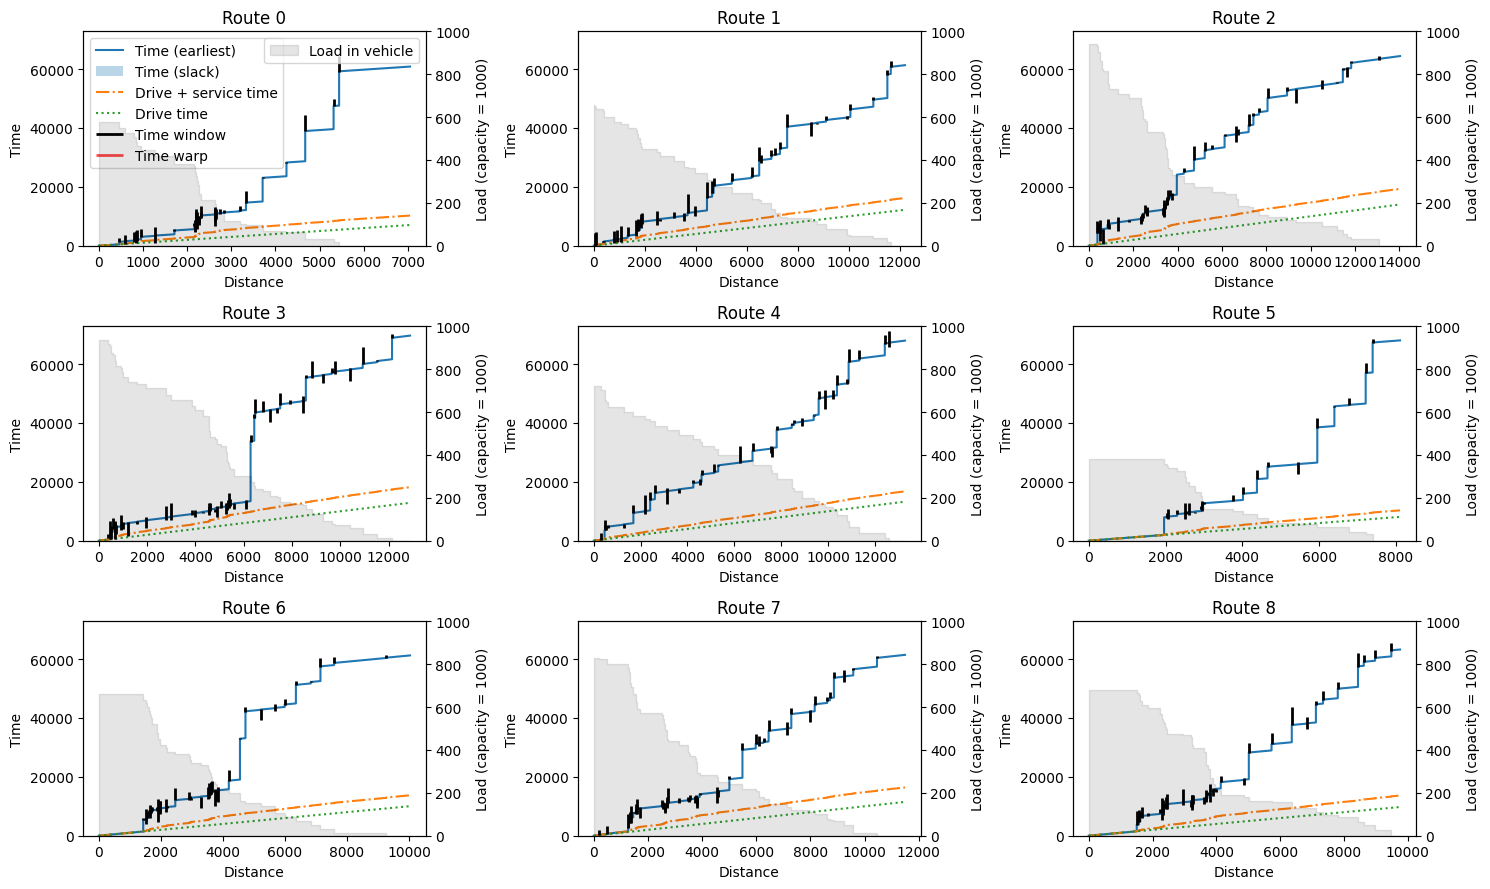

In [10]:
# Create directory, download instance and best known solution
gh_dir = data_dir / "vrptw" / "GH"
gh_dir.mkdir(parents=True, exist_ok=True)

# Download an instance and best known solution
instance_name_gh = "RC2_10_5"
instance_filename_gh = gh_dir / f"{instance_name_gh}.vrp"
if not instance_filename_gh.exists():
    vrplib.download_instance(instance_name_gh, instance_filename_gh)
instance_bks_filename_gh = gh_dir / f"{instance_name_gh}.sol"
if not instance_bks_filename_gh.exists():
    vrplib.download_solution(instance_name_gh, instance_bks_filename_gh)

# Read, convert and plot instance
instance_gh = read(
    instance_filename_gh, instance_format="solomon", round_func="trunc1"
)
instance_gh_bks = vrplib.read_solution(instance_bks_filename_gh)
fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance_gh, fig)

# Run HGS algorithm and plot result
args = {"seed": 42, "max_runtime": 30}
result_gh = solve(instance_gh, **args)
print(
    f"Total cost of solution: {result_gh.best.cost() / 10}, BKS = {instance_gh_bks['cost']}"
)
fig = plt.figure(figsize=(15, 9))
plotting.plot_result(result_gh, instance_gh, fig)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(15, 9))
for i, (ax, route) in enumerate(
    zip(axarr.reshape(-1), result_gh.best.get_routes())
):
    plotting.plot_route_schedule(
        instance_gh, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()

### ORTEC instance (from the EURO Meets NeurIPS 2022 Competition)
Let's also try an instance based on real data, which uses an actual over-the-road distance matrix (non-Euclidean) and a-typical client distribution. Note that the file is in `vrplib` format and the distances are already integral and so there is no rounding.

Total cost of solution: 263366


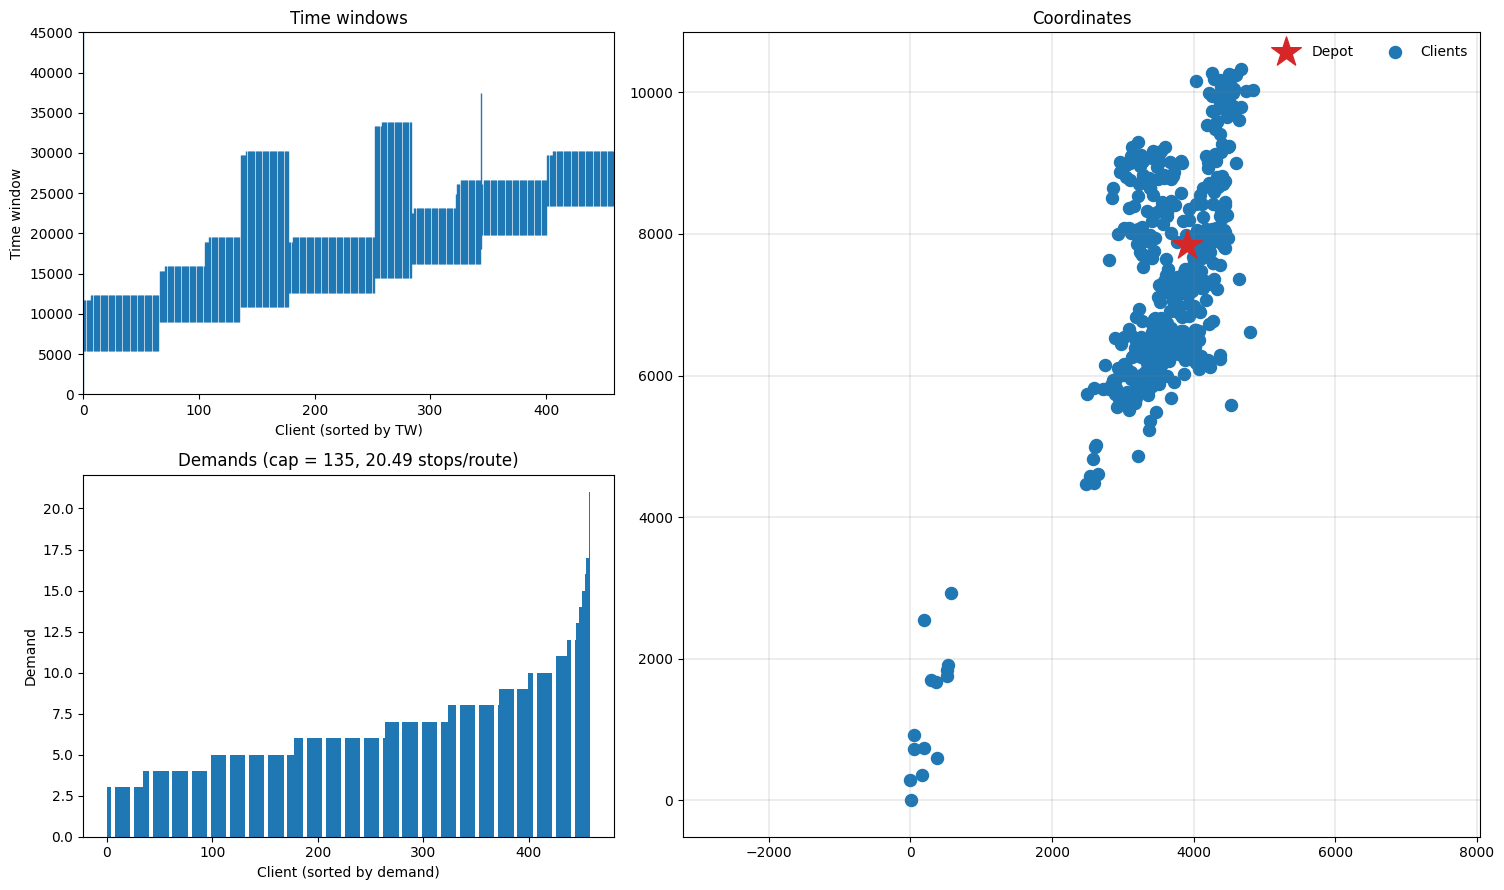

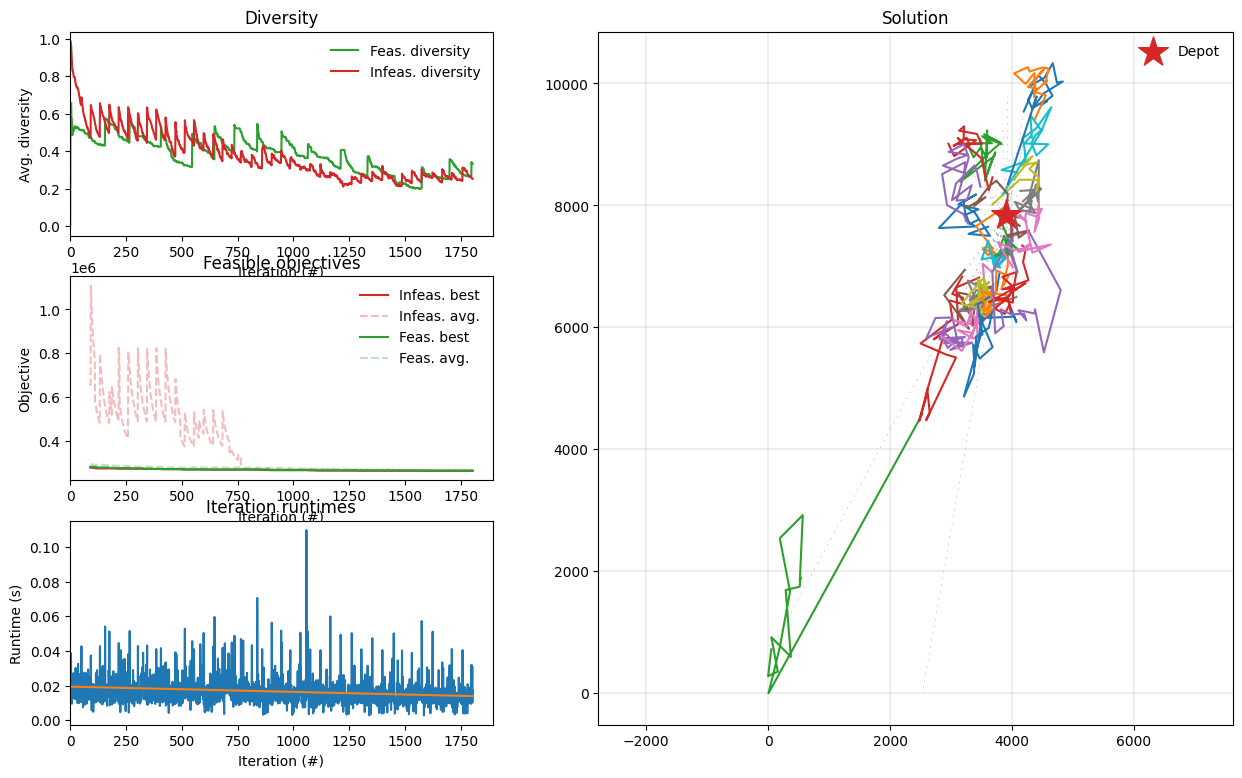

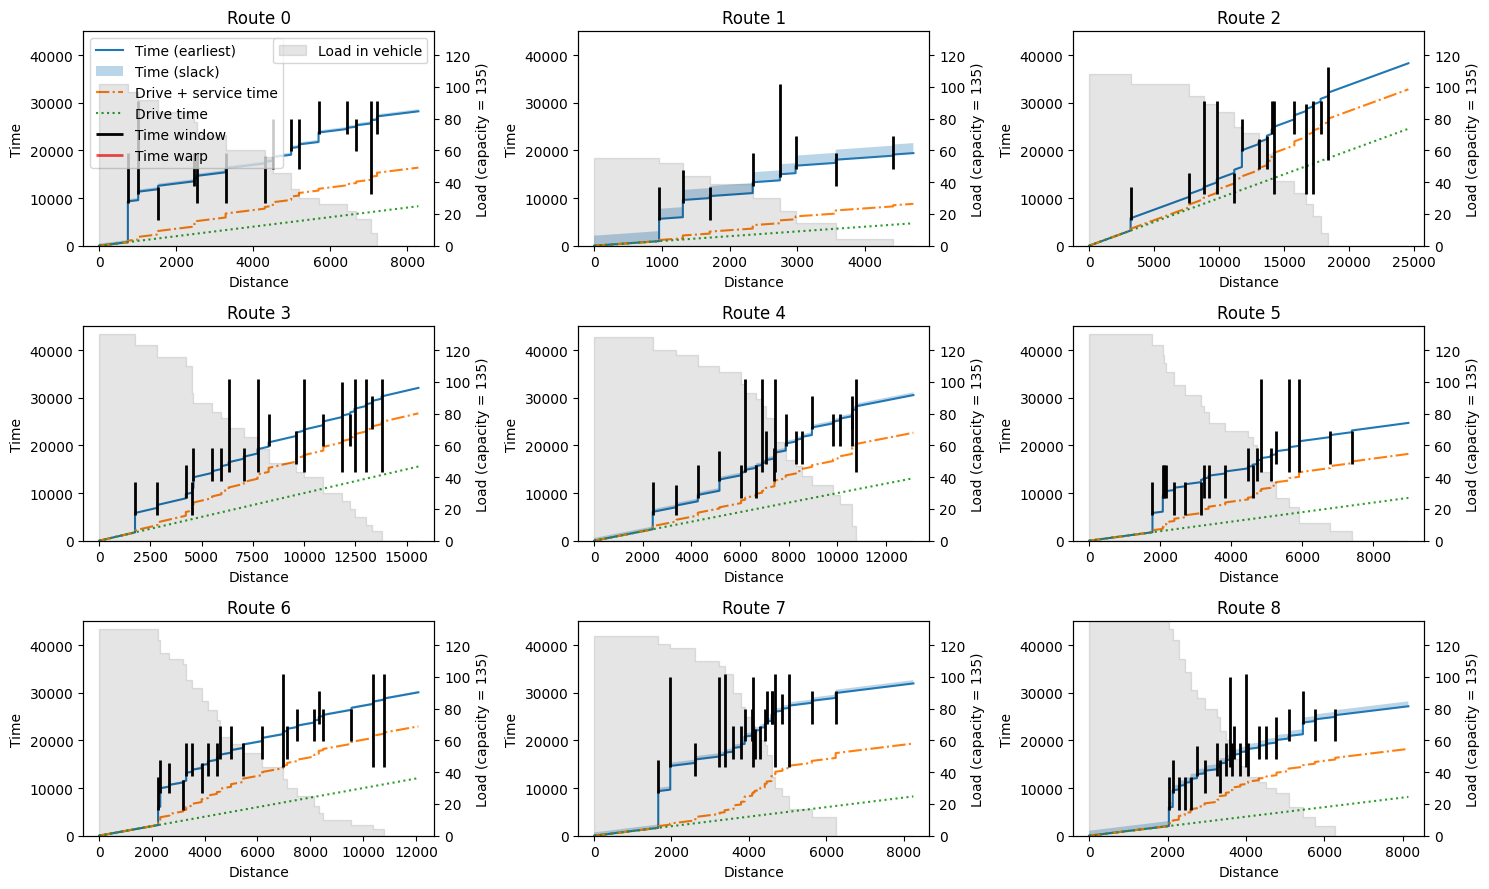

In [11]:
# Create directory and download instance
ortec_dir = data_dir / "vrptw" / "ORTEC"
ortec_dir.mkdir(parents=True, exist_ok=True)

# Read, convert and plot instance
# # instance_name_ortec = "ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12"
instance_name_ortec = "ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35"
instance_filename_ortec = ortec_dir / f"{instance_name_ortec}.txt"
download_url = f"https://github.com/ortec/euro-neurips-vrp-2022-quickstart/raw/main/instances/{instance_name_ortec}.txt"
if not instance_filename_ortec.exists():
    ! wget -q -O {instance_filename_ortec} {download_url}

# Note: no need to round as these instances have explicit integer distance matrices
instance_ortec = read(instance_filename_ortec, instance_format="vrplib")
fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance_ortec, fig)

# Run HGS algorithm and plot result
args = {"seed": 42, "max_runtime": 30}
result_ortec = solve(instance_ortec, **args)
print(f"Total cost of solution: {result_ortec.best.cost()}")
fig = plt.figure(figsize=(15, 9))
plotting.plot_result(result_ortec, instance_ortec, fig)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(15, 9))
for i, (ax, route) in enumerate(
    zip(axarr.reshape(-1), result_ortec.best.get_routes())
):
    plotting.plot_route_schedule(
        instance_ortec, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()